# MPI parallelisation

We will need to install two packages:

- The actual MPI library:

```
conda install openmpi
```

Or: 

```
conda install -c conda-forge openmpi
```

- The python MPI package:
```
conda install mpi4py
```


## 1. Basic python script:

Let's create a .py script that writes "Hello World":


```python
if __name__ == "__main__":

    print("Hello World!")
    
```

To execute it in a terminal:

```
wladimir$ python example_mpi1.py

Hello World!
```


## 2. Getting Started with MPI

Let’s try running this code on multiple processes. This is done using the **mpiexec** command.

Many environments also provide an **mpirun** command, which usually - but not always - works the same way. 

Whenever possible, you should use mpiexec and not mpirun, in order to guarantee more consistent results.

### MPI - mpiexec vs mpirun

- MPI stands for **‘message passing interface’** and is a message passing standard which is designed to work on a variety of parallel computing architectures.


- The MPI standard defines how syntax and semantics of a library of routines. There are a number of implementations of this standard including OpenMPI, MPICH, and MS MPI.


- The primary difference between mpiexec and mpirun is that mpiexec is defined as part of the MPI standard, while mpirun is not.


- Different implementations of MPI (i.e. OpenMPI, MPICH, MS MPI, etc.) are not guaranteed to implement mpirun, or might implement different options for mpirun.

- Technically, the MPI standard doesn’t actually require that MPI implementations implement mpiexec either, but the standard does at least describe guidelines for how mpiexec should work. Because of this, mpiexec is generally the preferred command.


The general format for launching a code on multiple processes is:

Let's create a **example2.py** script that writes "Hello World" and execute it in a terminal:


```
wladimir$ mpiexec -n 2 python example_mpi1.py
Hello World!
Hello World! 
```

When you execute the above command, mpiexec launches 2 different instances of python example_mpi1.py simultaneously, which each print “Hello World!”.

Typically, as long as you have at least 2 processors on the machine you are running on, each process will be launched on a different processor; however, certain environment variables and optional arguments to mpiexec can change this behavior. Each process runs the code in example_mpi1.py independently of the others.

### MPI communicator:

It might not be obvious yet, but the processes mpiexec launches aren’t completely unaware of one another. The mpiexec adds each of the processes to an MPI communicator, which enables each of the processes to send and receive information to one another via MPI. The MPI communicator that spans all of the processes launched by mpiexec is called **MPI.COMM_WORLD.**

In mpi4py, communicators are class objects, and we can query information about them through their class functions. Edit example_mpi2.py so that it reads as follows:

```python
from mpi4py import MPI

if __name__ == "__main__":

    world_comm = MPI.COMM_WORLD
    world_size = world_comm.Get_size()
    my_rank = world_comm.Get_rank()

    print("World Size: " + str(world_size) + "   " + "Rank: " + str(my_rank))
```

In the above code we first import mpi4py. Then, we get the communicator that spans all of the processes, which is called **MPI.COMM_WORLD.**

The communicator’s **Get_size()** function tells us the total number of processes within that communicator. Each of these processes is assigned a unique rank, which is an integer that ranges from **0** to **world_size - 1**.

The rank of a process allows it to be identified whenever processes communicate with one another. For example, in some cases we might want rank 2 to send some information to rank 4, or we might want rank 0 to receive information from all of the other processes.

Calling **world_comm.Get_rank()** returns the rank of the process that called it within world_comm.


Then, we execute it in a terminal:

```
wladimir$ mpiexec -n 2 python example_mpi2.py
World Size: 2   Rank: 0
World Size: 2   Rank: 1
```


As we can see, the **world_comm.Get_size()** function returns 2, which is the total number of ranks we told mpiexec to run with (through the -n argument). Each of the processes is assigned a rank in the range of 0 to 1.

The ranks may not necessarily print out their messages in order; whichever rank reaches the print function first will print out its message first. If you run the code again with more processors, the ranks are likely to print their messages in a different order.

## 3. Basic Infrastructure

We will now do some work with the script in **example_mpi3.py**, which does some simple math with NumPy arrays:

```python
from mpi4py import MPI
import numpy as np

if __name__ == "__main__":

    N = 10000000

    # initialize a
    a = np.ones( N )

    # initialize b
    b = np.zeros( N )
    for i in range( N ):
        b[i] = 1.0 + i

    # add the two arrays
    for i in range( N ):
        a[i] = a[i] + b[i]

    # average the result
    sum = 0.0
    for i in range( N ):
        sum += a[i]
    average = sum / N

    print("Average: " + str(average))
```


Then, run it:

```
wladimir$ python example_mpi3.py
Average: 5000001.5
```

### MPI wall time

Let’s learn something about which parts of this code account for most of the run time. **mpi4py** provides a timer, **MPI.Wtime()**, which returns the current walltime. We can use this function to determine how long each section of the code takes to run.

For example, to determine how much time is spent initializing array **a**, do the following in example_mpi4.py:

```python 
    # initialize a
    start_time = MPI.Wtime()
    a = np.ones(N)
    end_time = MPI.Wtime()
    if my_rank == 0:
        print("Initialize a time: " + str(end_time-start_time))
```

As the above code indicates, we don’t really want every rank to print the timings, since that could look messy in the output. Instead, we have only rank 0 print this information. Of course, this requires that we add a few lines near the top of the code to query the rank of each process:

```python
    # get basic information about the MPI communicator
    world_comm = MPI.COMM_WORLD
    world_size = world_comm.Get_size()
    my_rank = world_comm.Get_rank()
    
```

Also determine and print the timings of each of the other sections of the code: the intialization of array **b**, the addition of the two arrays, and the final averaging of the result. Your code should look something like this:

```python 
#!/usr/bin/env python

from mpi4py import MPI
import numpy as np

# get basic information about the MPI communicator
world_comm = MPI.COMM_WORLD
world_size = world_comm.Get_size()
my_rank = world_comm.Get_rank()

if __name__ == "__main__":

    N = 10000000

    # initialize a
    start_time = MPI.Wtime() # Adding time stamp
    a = np.ones(N)
    end_time   = MPI.Wtime() # Adding time stamp

    # Print the time
    if my_rank == 0:
        print("Initialise a time: " + str(end_time - start_time))

    # initialize b
    start_time1 = MPI.Wtime() # Adding time stamp
    b = np.zeros(N)
    for i in range(N):
        b[i] = 1.0 + i
    end_time1    = MPI.Wtime() # Adding time stamp

    # Print the time
    if my_rank == 0:
        print("Initialise b time: " + str(end_time1 - start_time1))

    # add the two arrays
    start_time2 = MPI.Wtime() # Adding time stamp
    for i in range(N):
        a[i] = a[i] + b[i]
    end_time2 = MPI.Wtime() # Adding time stamp

    # Print the time
    if my_rank == 0:
        print("Adding arrays time: " + str(end_time2 - start_time2))

    # average the result
    start_time3 = MPI.Wtime() # Adding time stamp
    sum = 0.0
    for i in range(N):
        sum += a[i]
    average = sum / N
    end_time3 = MPI.Wtime() # Adding time stamp

    if my_rank == 0:
        print("Averaging result time: " + str(end_time3 - start_time3))
        print("Average: " + str(average))```
```

Run this with one and several cores:

#### Serial run:
```
wladimir$ python example_mpi4.py 
Initialise a time: 0.03160300000000005
Initialise b time: 1.683021
Adding arrays time: 3.578656
Averaging result time: 2.1059520000000003
Average: 5000001.5
```

#### Parallel Run:
```
mpirun -n 2 python example_mpi4.py 
Initialise a time: 0.033883
Initialise b time: 1.6831939999999999
Adding arrays time: 3.9273849999999997
Averaging result time: 2.986340000000001
Average: 5000001.5
```

## 4. Point-to-Point Communication

We can see that running on multiple ranks doesn’t help with the timings, because each rank is duplicating all of the same work.

We want the ranks to cooperate on the problem, with each rank working on a different part of the calculation. In this example, that means that different ranks will work on different parts of the arrays **a** and **b**, and then the results on each rank will be summed across all the ranks.

We need to decide what parts of the arrays each of the ranks will work on; this is more generally known as a rank’s workload. Add the following code just before the initialization of array **a** in example_mpi6.py:

```python 
    # determine the workload of each rank
    workloads = [ N // world_size for i in range(world_size) ]
    for i in range( N % world_size ):
        workloads[i] += 1
    my_start = 0
    for i in range( my_rank ):
        my_start += workloads[i]
    my_end = my_start + workloads[my_rank]
```

In the above code, **my_start** and **my_end** represent the range over which each rank will perform mathematical operations on the arrays.

#### Serial Run: 

```
wladimir$ python example_mpi5.py 
Printing workloads: [10000000]
Printing my_start: 0
Printing my_end: 10000000
Initialise a time: 0.055971
Initialise b time: 1.6320759999999999
Adding arrays time: 3.598573
Averaging result time: 1.9293189999999996
Average: 5000001.5
```

#### Parallel Run: 

```
mpirun -n 2 python example_mpi5.py 
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Initialise a time: 0.111718
Initialise b time: 1.808382
Adding arrays time: 4.003725
Averaging result time: 2.0773859999999997
Average: 5000001.5
```


This script is still not helping with times, so we’ll start by parallelizing the code that averages the result in example_mpi6.py. Update the range of the for loop in this part of the code to the following:

```python 
    for i in range( my_start, my_end ):
    
```

This will ensure that each rank is only calculating elements **my_start** through **my_end** of the sum. We then need the ranks to communicate their individually calculated sums so that we can calculate the global sum. To do this, replace the line **average = sum / N** with:


```python 
    if my_rank == 0:
        world_sum = sum
        for i in range( 1, world_size ):
      	    sum_np = np.empty( 1 )
            world_comm.Recv( [sum_np, MPI.DOUBLE], source=i, tag=77 )
            world_sum += sum_np[0]
        average = world_sum / N
    else:
        sum_np = np.array( [sum] )
        world_comm.Send( [sum_np, MPI.DOUBLE], dest=0, tag=77 )
```

The **MPI.DOUBLE** parameter tells MPI what type of information is being communicated by the **Send** and **Recv** calls. In this case, we are sending an array of double precision numbers. If you are communicating information of a different datatype, consult the following:



#### Serial run:
```
wladimir$ python example_mpi4.py 
Initialise a time: 0.03160300000000005
Initialise b time: 1.683021
Adding arrays time: 3.578656
Averaging result time: 2.1059520000000003
Average: 5000001.5
```

#### Parallel run:

```
$ mpirun -n 2 python example_mpi6.py 
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Initialise a time: 0.049703
Initialise b time: 1.733414
Adding arrays time: 3.9768729999999994
Averaging result time: 0.9668559999999999
Average: 5000001.5
```

You can see that the amount of time spent calculating the average has indeed gone down.

### Parallelisation of the sum of two arrays:

Parallelizing the part of the code that adds the two arrays is much easier. All we need to do is update the range over which the for loop iterates:

```python
    for i in range(my_start, my_end):
```

#### Comparison:

```
wladimir$ mpirun -n 2 python example_mpi6.py 
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Initialise a time: 0.033704
Initialise b time: 1.729189
Adding arrays time: 3.9222249999999996
Averaging result time: 1.2841199999999997
Average: 5000001.5
```


```
wladimir$ mpirun -n 2 python example_mpi7.py 
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Initialise a time: 0.033571
Initialise b time: 1.8027939999999998
Adding arrays time: 1.8451830000000002
Averaging result time: 1.4243779999999995
Average: 5000001.5
```

The array addition time has gone down nicely. Surprisingly enough, the most expensive part of the calculation is now the initialization of array b. 

### Parallelisation of the initialisation of b:

Updating the range over which that loop iterates speeds up that part of the calculation:

```python
    for i in range(my_start, my_end):
```

#### Comparison:

```
wladimir$ mpirun -n 2 python example_mpi7.py 
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Initialise a time: 0.033571
Initialise b time: 1.8027939999999998
Adding arrays time: 1.8451830000000002
Averaging result time: 1.4243779999999995
Average: 5000001.5
```

```
wladimir$ mpirun -n 2 python example_mpi8.py 
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Initialise a time: 0.066303
Initialise b time: 0.848179
Adding arrays time: 1.8135150000000002
Averaging result time: 1.1754170000000004
Average: 5000001.5
```

### Reducing the Memory Footprint

The simulation is running much faster now thanks to the parallelization we have added. If that’s all we care about, we could stop working on the code now.

In reality, though, time is only one resource we should be concerned about. Another resource that is often even more important is memory.

The changes we have made to the code make it run faster, but don’t decrease its memory footprint in any way: 


- Each rank allocates arrays **a** and **b** with **N** double precision values.


- That means that each rank allocates **2N** double precision values; across all of our ranks, that corresponds to a total of **2 * nproc * world_size** double precision values.


- **Running on more processors might decrease our run time, but it increases our memory footprint!**

Of course, there isn't really a good reason for each rank to allocate the entire arrays of size **N**, because each rank will only ever use values within the range of **my_start** to **my_end**. Let’s modify the code so that each rank allocates **a** and **b** to a size of **workloads[my_rank]**.


Replace the initialization of **a** with:

```
    a = np.ones( workloads[my_rank] )
```
Replace the initialization of b with:

```
    b = np.zeros( workloads[my_rank] )
    for i in range( workloads[my_rank] ):
        b[i] = 1.0 + ( i + my_start )
```

Replace the range of the loops that add and sum the arrays to **range(workloads[my_rank])**.


Then, run the code:

```
wladimir$ mpirun -np 2 python example_mpi9.py
Printing workloads: [5000000, 5000000]
Printing my_start: 0
Printing my_end: 5000000
Printing workloads: [5000000, 5000000]
Printing my_start: 5000000
Printing my_end: 10000000
Initialise a time: 0.018729
Initialise b time: 1.109134
Adding arrays time: 2.01623
Averaging result time: 1.0165069999999998
Average: 5000001.5
```

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
df = pd.read_csv("./execution_times.txt", header = None)

n = df[0]
t = df[1]

t_ideal = np.asarray(np.full(n.shape, t[0])/n)

print(t_ideal)

[0.836637   0.4183185  0.20915925 0.10457963]


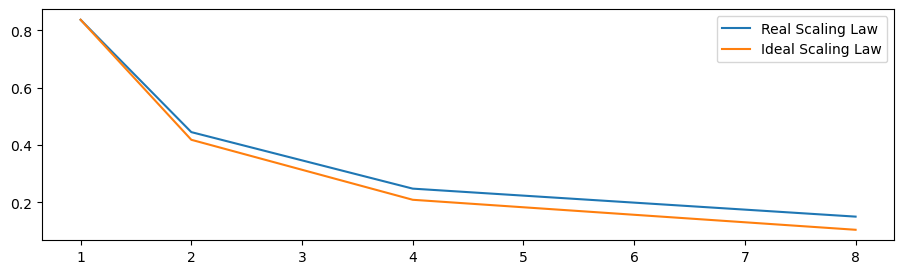

In [24]:
plt.figure(figsize= (11, 3))

plt.plot(n, t, label = "Real Scaling Law")

plt.plot(n, t_ideal, label = "Ideal Scaling Law")

plt.legend()
plt.show()

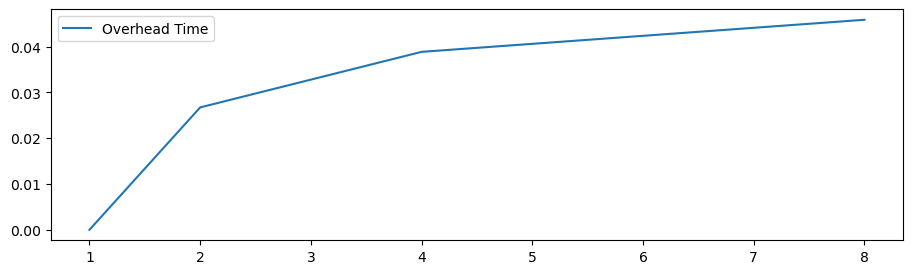

In [25]:
plt.figure(figsize= (11, 3))

plt.plot(n, t-t_ideal, label = "Overhead Time")

plt.legend()
plt.show()